## Overvieww

This notebook performs time series analysis on the SPY and options datasets from March 11–15, 2024. The goal is to explore how key trading variables change over time and check for any repeating or cyclical patterns. We look at how prices and trading activity evolve through the week, identify intraday volume peaks, and detect any long pauses or irregular timing in the data. The results help describe the short-term market dynamics and daily trading behavior across different sampling intervals

## Time Series Analysis Setup

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['axes.grid'] = False

def to_dt(s): return pd.to_datetime(s)

def pick_price(df):
    for c in ["close","vwap","price","open"]:
        if c in df.columns: return c
    return None

def pick_activity(df):
    for c in ["volume","transactions","size"]:
        if c in df.columns: return c
    return None

def prep(df):
    d = df.copy()
    d = d.dropna(subset=["datetime_et"])
    d["datetime_et"] = to_dt(d["datetime_et"])
    d.sort_values("datetime_et", inplace=True)
    return d

def ts_trend(df, name):
    d = prep(df); ycol = pick_price(d)
    if not ycol: return
    fig, ax = plt.subplots()
    ax.plot(d["datetime_et"], pd.to_numeric(d[ycol], errors="coerce"), lw=1)
    ax.set_title(f"{name}: {ycol} over time")
    ax.tick_params(axis='x', rotation=45); ax.grid(True, axis='y'); fig.tight_layout(); plt.show()
    y = pd.to_numeric(d[ycol], errors="coerce")
    print(f"{name}: {ycol} change = {y.iloc[-1]-y.iloc[0]:.3f}")

def ts_intraday(df, name):
    d = prep(df); acol = pick_activity(d)
    if not acol: return
    d["tod"] = d["datetime_et"].dt.strftime("%H:%M")
    g = d.groupby("tod")[acol].mean().reset_index().sort_values("tod")
    y = np.log1p(pd.to_numeric(g[acol], errors="coerce")).values
    x = np.arange(len(g))
    fig, ax = plt.subplots(figsize=(9,4))
    ax.plot(x, y, lw=1)
    step = 30
    ax.set_xticks(x[::step]); ax.set_xticklabels(g["tod"].iloc[::step])
    ax.set_title(f"{name}: avg log1p({acol}) by time")
    ax.grid(True, axis='y'); fig.tight_layout(); plt.show()
    print(f"{name}: peak {acol} ~{g.loc[y.argmax(),'tod']}")

def ts_daily(df, name):
    d = prep(df); acol = pick_activity(d)
    if not acol: return
    g = d.groupby(d["datetime_et"].dt.date)[acol].sum()
    fig, ax = plt.subplots()
    ax.bar(g.index.astype(str), np.log1p(g.values))
    ax.set_title(f"{name}: daily log1p({acol})")
    ax.tick_params(axis='x', rotation=45); ax.grid(True, axis='y'); fig.tight_layout(); plt.show()
    print(f"{name}: max day {g.idxmax()}")

def ts_gaps(df, name, min_gap_s=120):
    d = prep(df)
    wk = d["datetime_et"].dt.weekday < 5
    tm = d["datetime_et"].dt.time
    d = d[wk & (tm>=pd.to_datetime("09:30").time()) & (tm<=pd.to_datetime("16:00").time())]
    if d.empty:
        print(f"{name}: no RTH data"); return
    g = d.groupby(d["datetime_et"].dt.date)["datetime_et"].diff().dt.total_seconds()
    g = g[g >= min_gap_s].dropna()
    if g.empty:
        print(f"{name}: no intraday gaps ≥ {min_gap_s}s"); return
    fig, ax = plt.subplots()
    ax.hist(g, bins=30); ax.set_title(f"{name}: intraday gaps ≥ {min_gap_s}s")
    ax.grid(True, axis='y'); fig.tight_layout(); plt.show()
    print(f"{name}: max gap = {g.max():.0f}s")

def run_time_series(dfs, show=None):
    for name, df in dfs.items():
        if show and name not in show: continue
        print(f"\n=== {name}: Time Series Analysis ===")
        ts_trend(df, name)
        ts_intraday(df, name)
        ts_daily(df, name)
        ts_gaps(df, name, 120)

*Pathing*

In [11]:
paths = {
    "SPY_trades": "../data/SPY_trades_clean_2024-03-11_2024-03-15.csv",
    "SPY_1s": "../data/SPY_1s_clean_2024-03-11_2024-03-15.csv",
    "SPY_1m": "../data/SPY_1m_clean_2024-03-11_2024-03-15.csv",
    "OPT_trades": "../data/OPT_trades_clean_2024-03-11_2024-03-15.csv",
    "OPT_1s": "../data/OPT_1s_clean_2024-03-11_2024-03-15.csv",
    "OPT_1m": "../data/OPT_1m_clean_2024-03-11_2024-03-15.csv",
}

dfs = {name: pd.read_csv(p) for name,p in paths.items()}

## Time Series Analysis


=== SPY_trades: Time Series Analysis ===


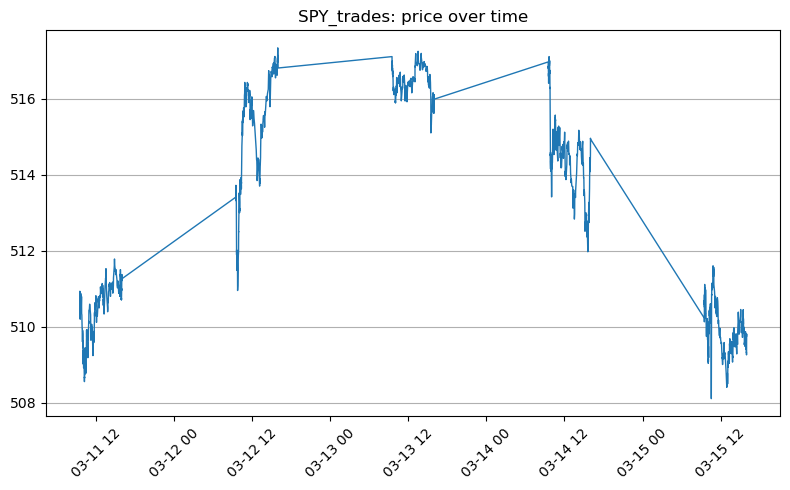

SPY_trades: price change = -0.720


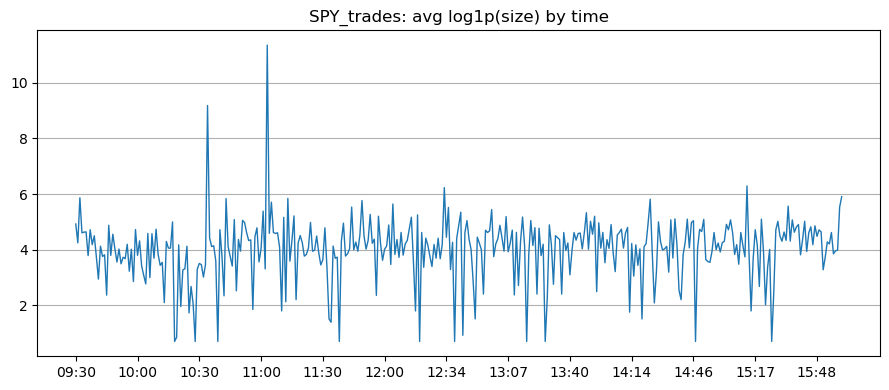

SPY_trades: peak size ~11:03


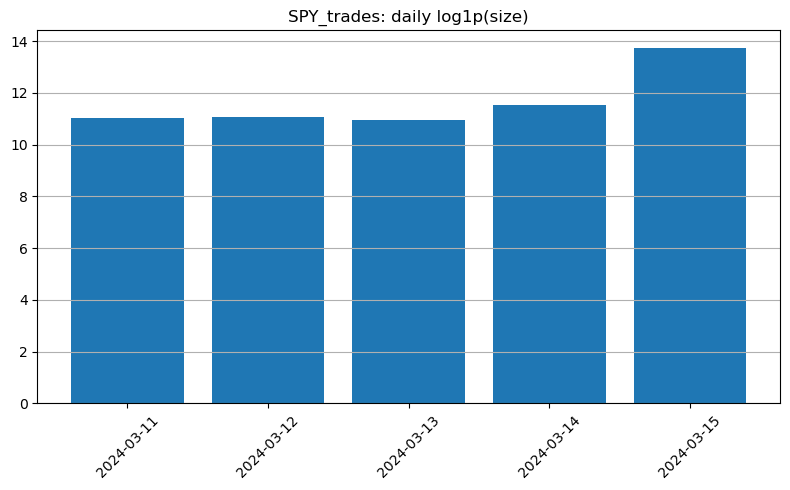

SPY_trades: max day 2024-03-15


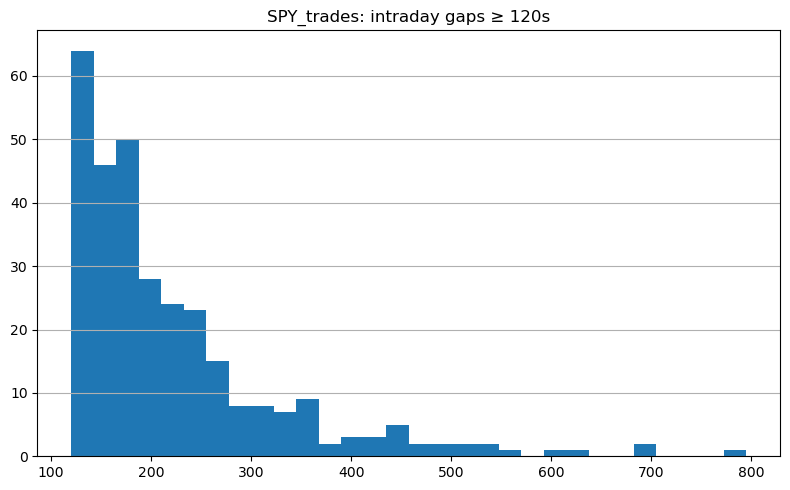

SPY_trades: max gap = 795s

=== SPY_1s: Time Series Analysis ===


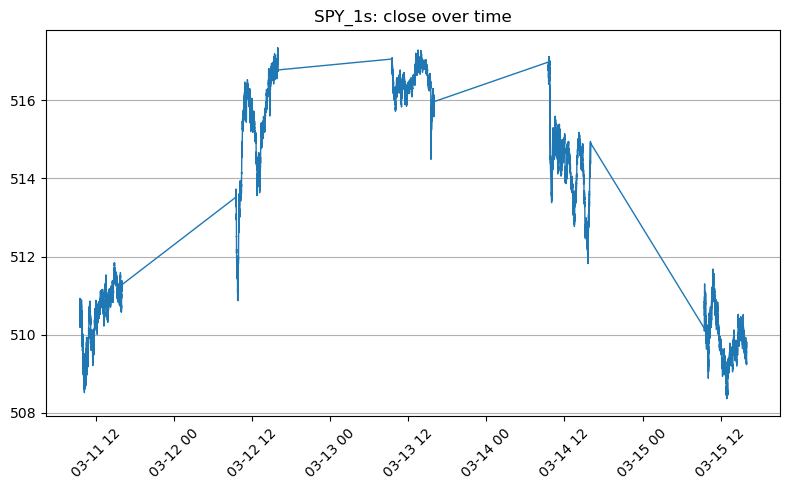

SPY_1s: close change = -0.730


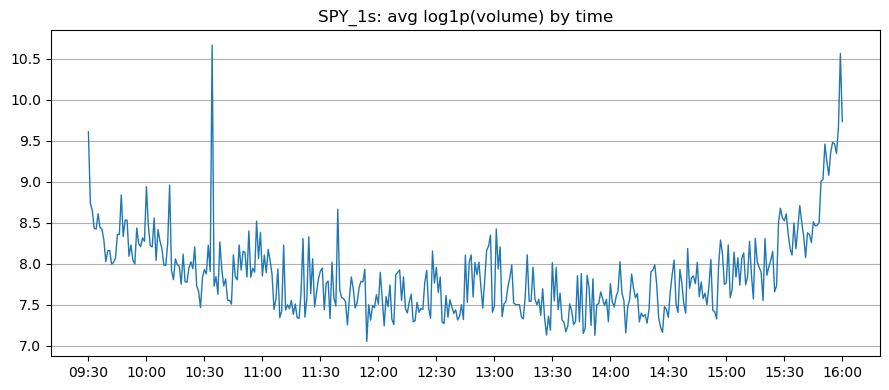

SPY_1s: peak volume ~10:34


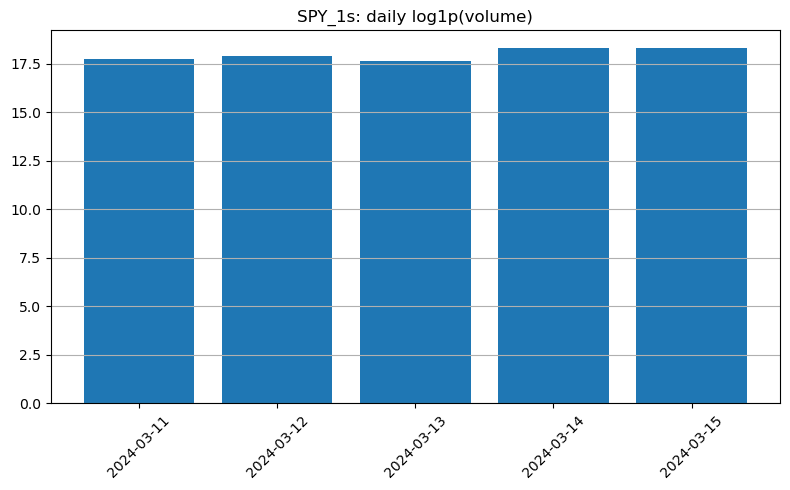

SPY_1s: max day 2024-03-14
SPY_1s: no intraday gaps ≥ 120s

=== SPY_1m: Time Series Analysis ===


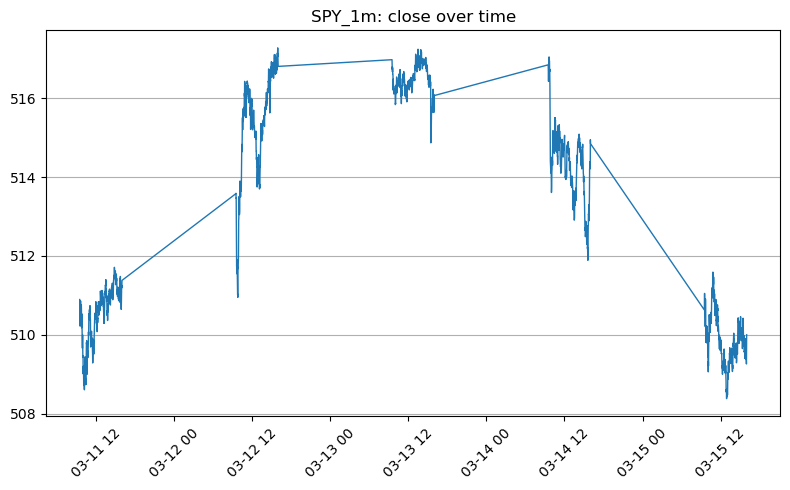

SPY_1m: close change = -0.895


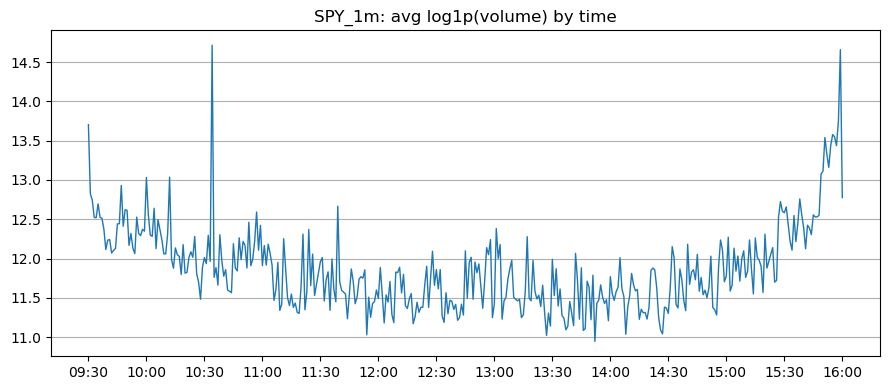

SPY_1m: peak volume ~10:34


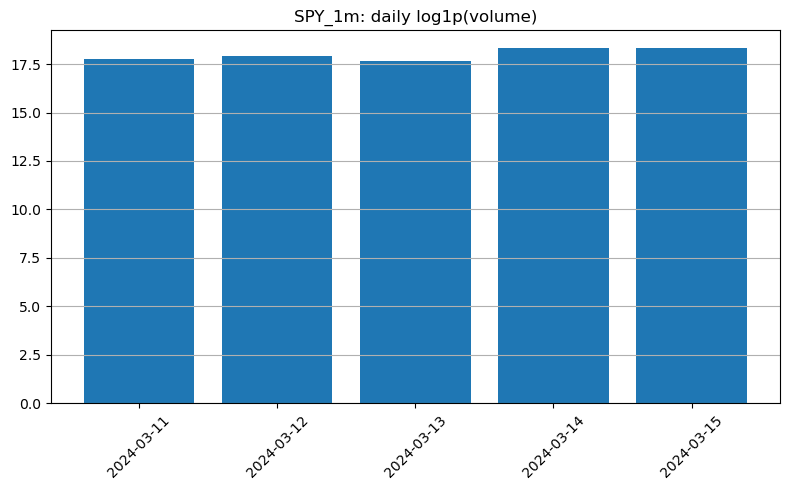

SPY_1m: max day 2024-03-15
SPY_1m: no intraday gaps ≥ 120s

=== OPT_trades: Time Series Analysis ===


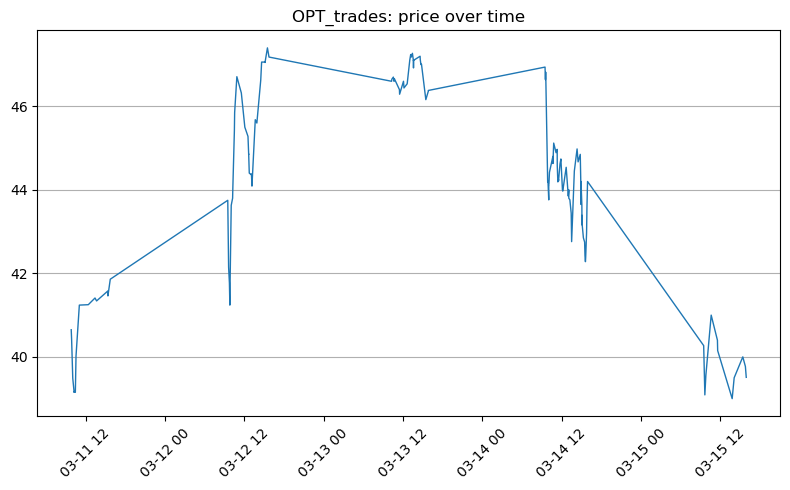

OPT_trades: price change = -1.140


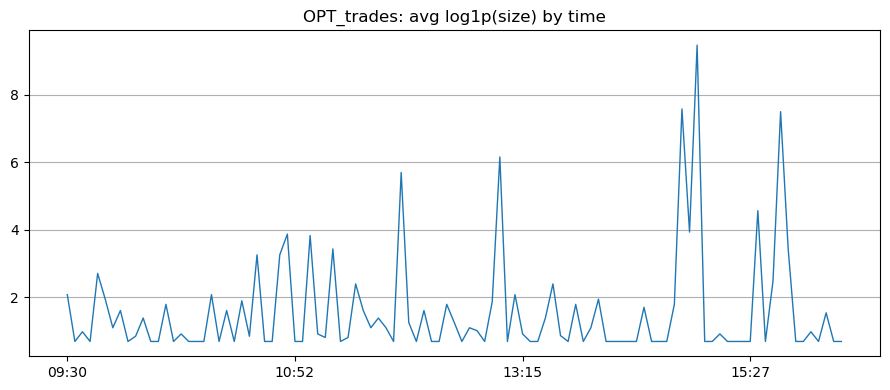

OPT_trades: peak size ~15:05


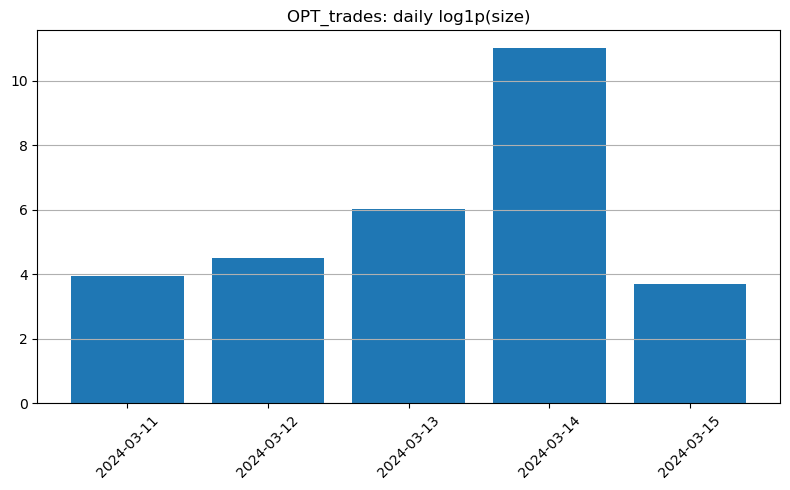

OPT_trades: max day 2024-03-14


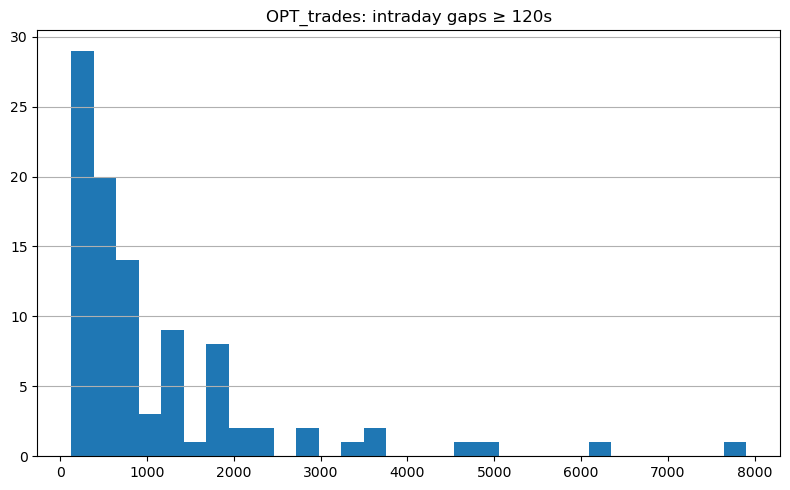

OPT_trades: max gap = 7903s

=== OPT_1s: Time Series Analysis ===


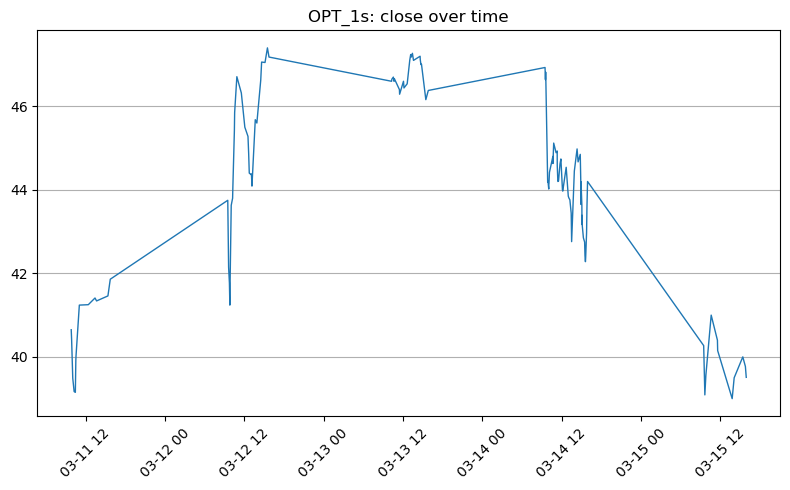

OPT_1s: close change = -1.140


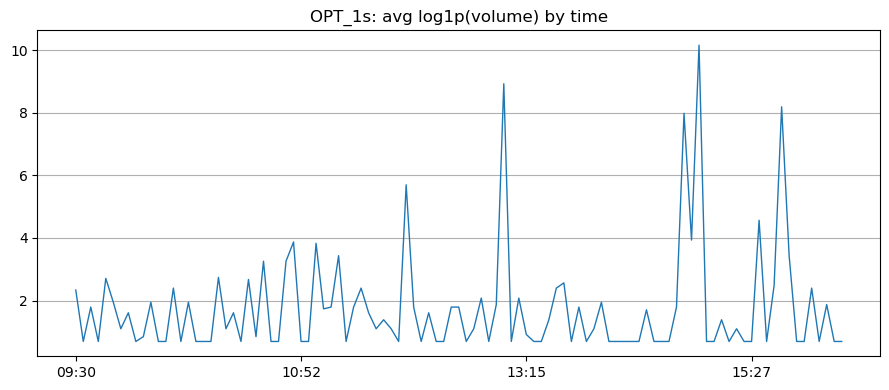

OPT_1s: peak volume ~15:05


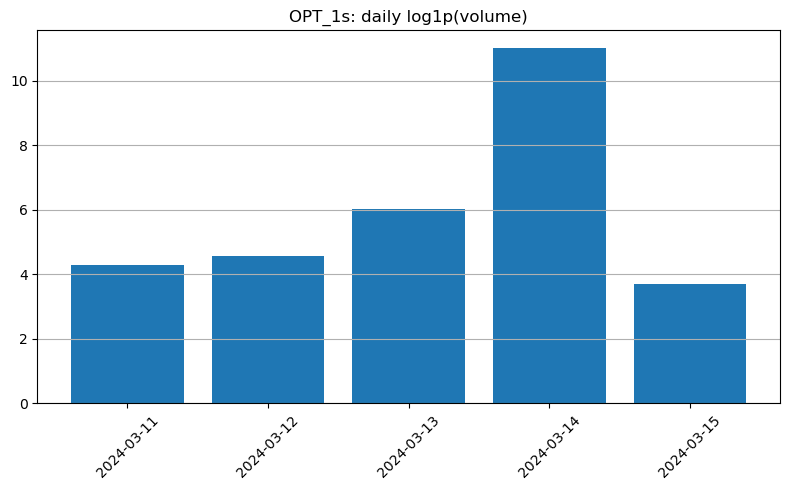

OPT_1s: max day 2024-03-14


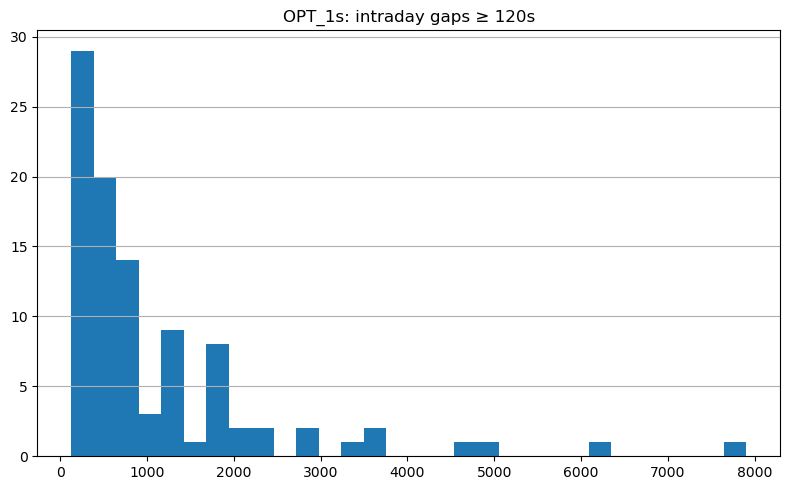

OPT_1s: max gap = 7903s

=== OPT_1m: Time Series Analysis ===


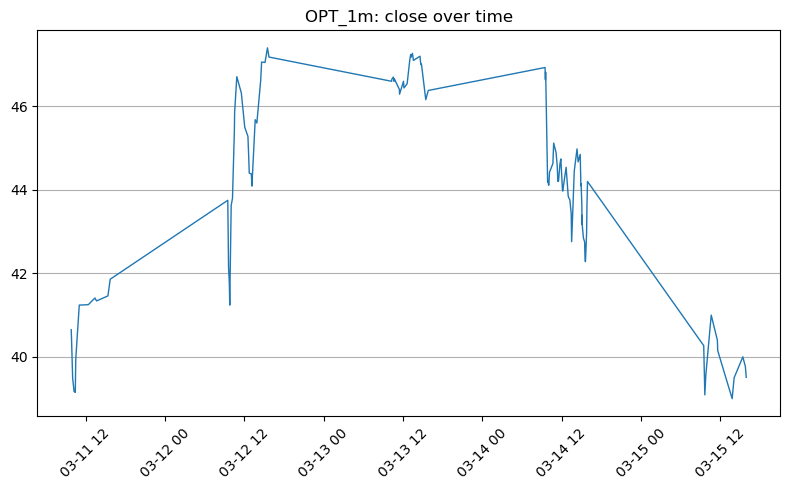

OPT_1m: close change = -1.140


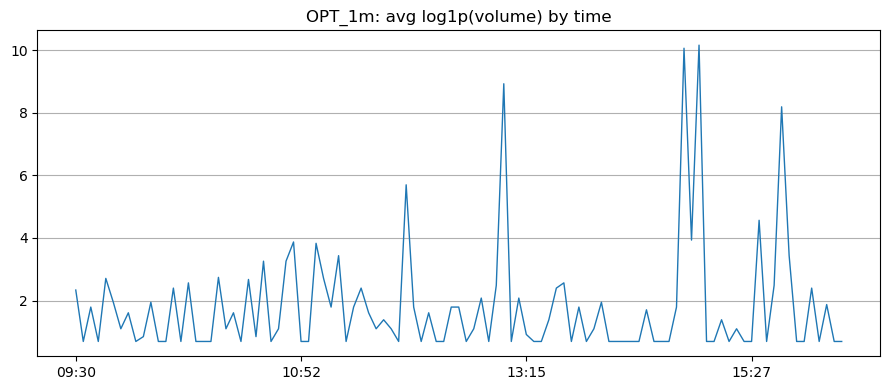

OPT_1m: peak volume ~15:05


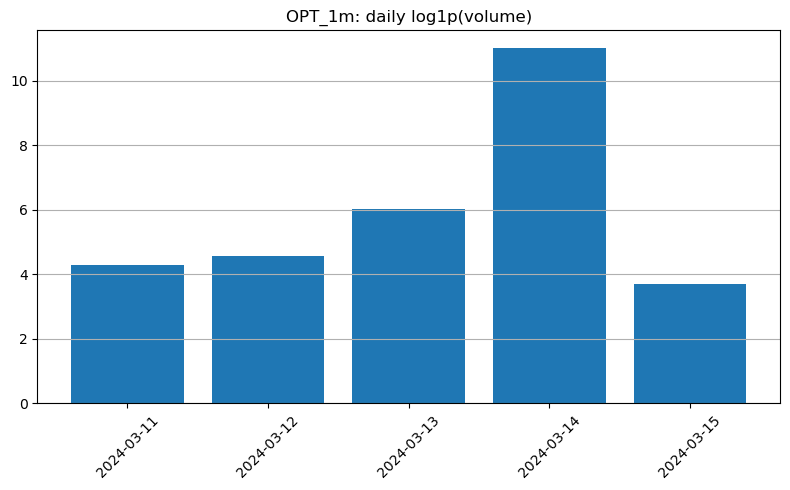

OPT_1m: max day 2024-03-14


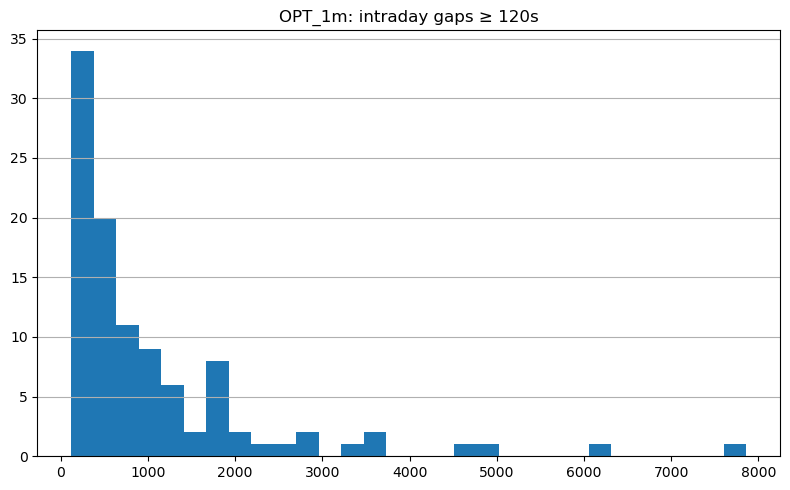

OPT_1m: max gap = 7860s


In [16]:
run_time_series(dfs_pat)

In [14]:
import pandas as pd
import numpy as np

def brief_attrs(dfs, time_col="datetime_et"):
    for name, df in dfs.items():
        r, c = df.shape
        keys = [k for k in ["open","high","low","close","price","vwap","volume","transactions","size"] if k in df.columns]
        print(f"\n{name}: {r}x{c} | keys={','.join(keys)}")
        if time_col in df.columns:
            dt = pd.to_datetime(df[time_col], errors="coerce").dropna().sort_values()
            if len(dt) >= 2:
                med = dt.diff().dt.total_seconds().dropna().median()
                print(f"time: {dt.iloc[0]} -> {dt.iloc[-1]} | freq≈{int(med)}s")
            else:
                print("time: n/a")
        else:
            print("time: column not found")

brief_attrs(dfs)


SPY_trades: 4727x6 | keys=price,size
time: 2024-03-11 09:30:05-04:00 -> 2024-03-15 16:00:00-04:00 | freq≈0s

SPY_1s: 105651x9 | keys=open,high,low,close,vwap,volume,transactions
time: 2024-03-11 09:30:00-04:00 -> 2024-03-15 16:00:00-04:00 | freq≈1s

SPY_1m: 1955x10 | keys=open,high,low,close,vwap,volume,transactions
time: 2024-03-11 09:30:00-04:00 -> 2024-03-15 16:00:00-04:00 | freq≈60s

OPT_trades: 192x6 | keys=price,size
time: 2024-03-11 09:49:00.129000-04:00 -> 2024-03-15 15:56:27.220000-04:00 | freq≈160s

OPT_1s: 128x9 | keys=open,high,low,close,vwap,volume,transactions
time: 2024-03-11 09:49:00-04:00 -> 2024-03-15 15:56:27-04:00 | freq≈491s

OPT_1m: 116x10 | keys=open,high,low,close,vwap,volume,transactions
time: 2024-03-11 09:49:00-04:00 -> 2024-03-15 15:56:00-04:00 | freq≈600s


## Interpretation Summary

The time series analysis for SPY and options data from March 11–15, 2024 shows normal and clear trading behavior. SPY has a daily cycle where trading is most active at market open and close, and slower in the middle of the day. Options data looks more random with some big spikes that probbaly come from nwes or big investors. Across all time levels the data looks stable, with no strange breaks or missing parts. Overall the time patterns make sense and the data can be used for more analysis later.